# A Neural Algorithm of Artistic Style

## Packages

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch import nn, optim
from torchvision import models, transforms
from PIL import Image

## Configuration

In [2]:
# device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)


# layers position
cont_layer = ['conv_3']
styl_layer = ['conv_1', 'conv_2', 'conv3', 'conv4', 'conv5']


# normalization
normalization_mean = torch.tensor([0.485, 0.456, 0.406])
normalization_stds = torch.tensor([0.229, 0.224, 0.225])


# fixed image size
image_h = 512 if torch.cuda.is_available() else 128
image_w = 512 if torch.cuda.is_available() else 128

## Tools

In [3]:
# processors
preprocess = transforms.Compose([
    transforms.Resize((image_h, image_w)),
    transforms.ToTensor(),
])
postprocess = transforms.ToPILImage()


# load image given a path
def load_image(path):
    # load iamge
    image = Image.open(path)
    # from PIL to tensor with batch
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float)


# show image given a tensor
def show_image(tensor, title=None):
    # copy fraom tensor on cpu
    image = tensor.cpu().clone()
    # remove batch
    image = image.squeeze(0)
    # from tensor to PIL image
    image = postprocess(image)
    if title is not None:
        plt.title(title)
    plt.imshow(image)


# compute gram of x (feature map)
def gram_matrix(x):
    b, c, h, w = x.shape
    # F belongs to R of N*M (N is b*c, M is h*w)
    features = x.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    # this is different from paper (2*N*M)^2
    return G.div(b * c * h * w)


# let optimizer manage pixels of input image
def get_optimizer(input_image):
    # [] operator is required
    return optim.LBFGS([input_image])

## Major (VGG-19)

In [4]:
# vgg net consists of features (convs & pool ...) & classifiers (fully connected part)
vgg_net = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.eval()

## Content Loss

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.loss = None
        # feature map of content in gram
        self.target = target.detach()

    def forward(self, x):
        # loss by mean squared error between feature map of generated & content
        self.loss = F.mse_loss(x, self.target)
        return x

## Style Loss

In [6]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.loss = None
        # feature map of style in gram
        self.target = gram_matrix(target).detach()

    def forward(self, x):
        # loss by mean squared error between feature map of generated & style in gram
        self.loss = F.mse_loss(gram_matrix(x), self.target)
        return x

## Normalization

In [7]:
class Normalization(nn.Module):
    def __init__(self, mean, stds):
        super(Normalization, self).__init__()
        # from (1, 3) to (3, 1, 1), match shape of (C, H, W)
        self.mean = mean.view(-1, 1, 1)
        self.stds = stds.view(-1, 1, 1)

    def forward(self, x):
        return (x - self.mean) / self.stds

## Extract & Combine

In [8]:
def build_network_with_losses(cont_img, styl_img, normalization_mean, normalization_stds):
    # transfer network, losses of content & style
    style_transfer_net = nn.Sequential()
    cont_losses = []
    styl_losses = []

    # normalization layer
    style_transfer_net.add_module("normalization", Normalization(normalization_mean, normalization_stds))

    # major body
    count = 0
    # scan layers of vgg-net
    for layer in vgg_net.children():
        if isinstance(layer, nn.Conv2d):
            count = count + 1
            layer_name = "conv_{}".format(count)
        elif isinstance(layer, nn.ReLU):
            layer_name = "relu_{}".format(count)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            layer_name = "pool_{}".format(count)
        elif isinstance(layer, nn.BatchNorm2d):
            layer_name = "bcnm_{}".format(count)
        else:
            raise RuntimeError("Unrecognized layer: {}".format(layer.__class__.__name__))

        # insert a layer of vgg-net into network
        style_transfer_net.add_module(layer_name, layer)

        # insert content-loss layer
        if layer_name in cont_layer:
            # compute content feature map
            target = style_transfer_net(cont_img).detach()
            # generate content-loss layer with target (feature map)
            cont_loss = ContentLoss(target)
            # insert the layer into network
            style_transfer_net.add_module("cont_loss_{}".format(count), cont_loss)
            # save content-loss for getting loss later
            cont_losses.append(cont_loss)

        # insert style-loss layer
        if layer_name in styl_layer:
            # compute style feature map
            target = style_transfer_net(styl_img).detach()
            # generate style-loss layer with target (feature map)
            styl_loss = StyleLoss(target)
            # insert the layer into network
            style_transfer_net.add_module("style_loss_{}".format(count), styl_loss)
            # save style-loss for getting loss later
            styl_losses.append(styl_loss)

    # trim redundant layers off
    for count in range(len(style_transfer_net) - 1, -1, -1):
        # until meeting any of content-loss layer or style-loss layer
        if isinstance(style_transfer_net[count], ContentLoss) or isinstance(style_transfer_net[count], StyleLoss):
            break
    style_transfer_net = style_transfer_net[:(count + 1)]

    return style_transfer_net, cont_losses, styl_losses

## reconstrcution

In [9]:
def make_transfer(in_img, cont_img, styl_img,
                  iterations, optimizer, cont_factor, styl_factor,
                  normalization_mean, normalization_stds):
    print("Building the style transfer net..")
    style_tarnsfer_net, cont_losses, styl_losses = build_network_with_losses(cont_img, styl_img, normalization_mean, normalization_stds)

    # set grads of input image (true) & network (false)
    in_img.requires_grad_(True)
    style_tarnsfer_net.eval()
    style_tarnsfer_net.requires_grad_(False)

    # training
    run = [0]
    while run[0] <= iterations:
        def closure():
            # to avoid some of pixels are out of (0, 1)
            with torch.no_grad():
                in_img.clamp_(0, 1)

            # loss in a iteration
            cont_total_loss = 0
            styl_total_loss = 0

            # forward
            style_tarnsfer_net(in_img)

            # sum of content-loss & style-loss with respective factors
            for cl in cont_losses:
                cont_total_loss = cont_total_loss + cl.loss
            for sl in styl_losses:
                styl_total_loss = styl_total_loss + sl.loss

            cont_total_loss = cont_total_loss * cont_factor
            styl_total_loss = styl_total_loss * styl_factor
            loss = cont_total_loss + styl_total_loss

            # backward
            optimizer.zero_grad()
            loss.backward()

            run[0] = run[0] + 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print("Style Loss: {:4f} Content Loss: {:4f}".format(styl_total_loss.item(), cont_total_loss.item()))
                print()

            return loss

        # there must be a closure, but i do not know why
        optimizer.step(closure)

    # as same as operation in closure
    with torch.no_grad():
        in_img.clamp_(0, 1)

    return in_img

## Experiments

Building the style transfer net..
run [50]:
Style Loss: 88.400452 Content Loss: 27.900137

run [100]:
Style Loss: 19.008982 Content Loss: 22.609192

run [150]:
Style Loss: 0.912785 Content Loss: 16.985287

run [200]:
Style Loss: 0.959736 Content Loss: 17.597982

run [250]:
Style Loss: 8.333879 Content Loss: 14.378462

run [300]:
Style Loss: 0.890196 Content Loss: 14.910320



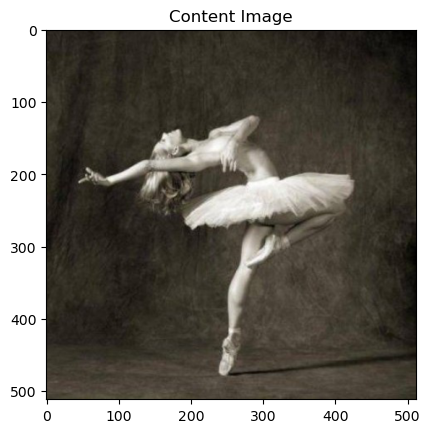

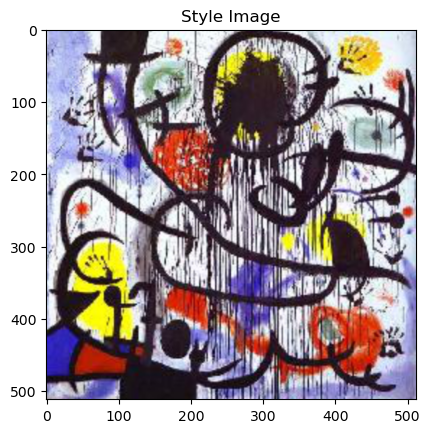

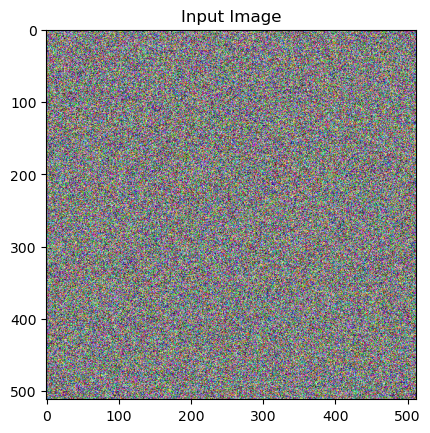

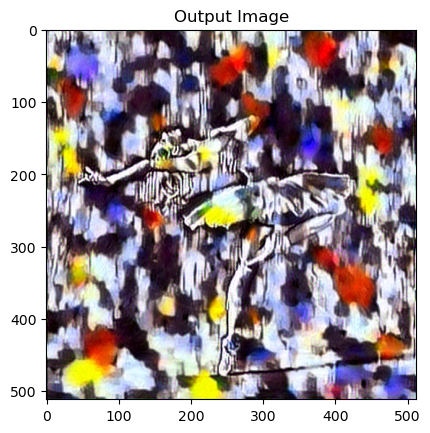

In [10]:
cont_image = load_image("../Images/Content/dancing.jpg")
plt.figure()
show_image(cont_image, "Content Image")

styl_image = load_image("../Images/Style/chaos.jpg")
plt.figure()
show_image(styl_image, "Style Image")

gene_image = torch.randn(cont_image.data.size())
# gene_image = cont_image.clone()
plt.figure()
show_image(gene_image, "Input Image")


out_image = make_transfer(gene_image, cont_image, styl_image,
                          300, get_optimizer(gene_image), 1, 1000000,
                          normalization_mean, normalization_stds)
plt.figure()
show_image(out_image, "Output Image")